# Proyek System Recommendation: [Book Recommendation System]
- **Nama:** I Dewa Gede Mahesta Parawangsa
- **Email:** dewamahesta2711@gmail.com
- **ID Dicoding:** demahesta

## Import Library

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import difflib
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

### Data Loading

In [ ]:
file_name = 'book.xlsx'

try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"File '{file_name}' not found. Make sure it's uploaded.")
except Exception as e:
    print(f"Incorrect file format or error: {e}")
else:
    print("Data loaded successfully:")
    print(df.head())

Data loaded successfully:
          isbn13   isbn10           title subtitle  \
0  9780000000000  2005883          Gilead      NaN   
1  9780000000000  2261987    Spider's Web  A Novel   
2  9780010000000  6163831    The One Tree      NaN   
3  9780010000000  6178731  Rage of angels      NaN   
4  9780010000000  6280897  The Four Loves      NaN   

                           authors                     categories  \
0               Marilynne Robinson                        Fiction   
1  Charles Osborne;Agatha Christie  Detective and mystery stories   
2             Stephen R. Donaldson               American fiction   
3                   Sidney Sheldon                        Fiction   
4              Clive Staples Lewis                 Christian life   

                                           thumbnail  \
0  http://books.google.com/books/content?id=KQZCP...   
1  http://books.google.com/books/content?id=gA5GP...   
2  http://books.google.com/books/content?id=OmQaw...   
3  http://

## Data Understanding

In [ ]:
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780000000000,2005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,385.0,247.0,361.0
1,9780000000000,2261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,383.0,241.0,5164.0
2,9780010000000,6163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,397.0,479.0,172.0
3,9780010000000,6178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,393.0,512.0,29532.0
4,9780010000000,6280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,415.0,170.0,33684.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6547 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [ ]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the table.')

There are 6810 rows and 12 columns in the table.


In [ ]:
df.columns

Index(['title', 'subtitle', 'authors', 'categories', 'description',
       'published_year', 'average_rating', 'num_pages', 'ratings_count',
       'combined_features'],
      dtype='object')

#### Penjelasan Kolom Dataset Buku

Berikut adalah penjelasan singkat untuk setiap kolom dalam dataset book.xlsx:

*   `isbn13`: Nomor ISBN (International Standard Book Number) 13 digit, kode unik pengenal buku secara internasional.
*   `isbn10`: Nomor ISBN 10 digit, kode unik pengenal buku (versi standar lama sebelum ISBN 13). Bertipe `object` (teks) karena bisa mengandung karakter 'X'.
*   `title`: Judul utama dari buku.
*   `subtitle`: Subjudul atau judul tambahan buku (kolom ini memiliki banyak nilai kosong/`null`).
*   `authors`: Nama penulis atau para penulis buku. Bisa berisi lebih dari satu nama.
*   `categories`: Kategori atau genre buku (misalnya, Fiksi, Sejarah, Komputer). Bisa berisi lebih dari satu kategori.
*   `thumbnail`: Tautan (URL) ke gambar sampul kecil (thumbnail) buku.
*   `description`: Ringkasan, sinopsis, atau deskripsi singkat mengenai isi buku.
*   `published_year`: Tahun buku pertama kali diterbitkan. (Bertipe `float64` mungkin karena adanya data yang hilang atau cara data dikumpulkan, idealnya integer).
*   `average_rating`: Rata-rata skor penilaian (rating) yang diberikan oleh pengguna untuk buku tersebut (misalnya, skala 1-5).
*   `num_pages`: Jumlah total halaman dalam buku. (Bertipe `float64`, kemungkinan alasan yang sama dengan `published_year`).
*   `ratings_count`: Jumlah total pengguna yang telah memberikan penilaian (rating) pada buku. (Bertipe `float64`, kemungkinan alasan yang sama).

In [ ]:
df.describe()

,isbn13,published_year,average_rating,num_pages,ratings_count
count,6.810000e+03,6804.000000,6767.000000,6767.000000,6.767000e+03
mean,9.780677e+12,1998.630364,354.418354,348.181026,2.106910e+04
std,6.067872e+08,10.484257,116.563100,242.376783,1.376207e+05
min,9.780000e+12,1853.000000,0.000000,0.000000,0.000000e+00
25%,9.780330e+12,1996.000000,367.000000,208.000000,1.590000e+02
50%,9.780550e+12,2002.000000,392.000000,304.000000,1.018000e+03
75%,9.780810e+12,2005.000000,412.000000,420.000000,5.992500e+03
max,9.789040e+12,2019.000000,491.000000,3342.000000,5.629932e+06


Berikut ringkasan informasi mengenai struktur dan tipe data dalam dataset book.xlsx:

*   Dataset ini memiliki **6810 sampel** (baris data atau entri buku).
*   Terdapat **12 fitur** (kolom) dalam dataset yang mendeskripsikan setiap buku.
*   Dataset terdiri dari **4 fitur** dengan tipe data `float64`, **1 fitur** dengan tipe data `int64`, dan **7 fitur** dengan tipe data `object` (umumnya teks/string).
*   Dataset ini berasal dari file berformat CSV (Comma-Separated Values).

In [ ]:
selected_features = ['title','authors','categories','published_year']
print(selected_features)

['title', 'authors', 'categories', 'published_year']


Alasan Pemilihan Fitur (`title`, `authors`, `categories`, `published_year`)

Fitur-fitur ini dipilih karena secara kolektif memberikan deskripsi inti tentang **konten dan konteks** buku, yang esensial untuk *content-based filtering*:

*   **`title`**: Kata kunci utama mengenai topik/cerita buku.
*   **`authors`**: Penulis seringkali menentukan gaya, tema, dan kualitas; pembaca sering mengikuti penulis favorit.
*   **`categories`**: Pengelompokan eksplisit berdasarkan genre atau subjek yang serupa.
*   **`published_year`**: Memberikan konteks waktu (era) yang dapat mempengaruhi gaya atau relevansi, meskipun mungkin sinyal konten yang lebih lemah dibanding yang lain.

In [ ]:
# Total rows in dataset
total_rows = len(df)

# Check missing values and categorical details
print(f"DATASET SUMMARY (TOTAL ROWS: {total_rows})\n")

for feature in selected_features:
    missing_count = df[feature].isnull().sum()
    missing_percent = (missing_count / total_rows) * 100
    non_missing = total_rows - missing_count
    complete_status = "✅ COMPLETE" if missing_count == 0 else "❌ MISSING"

    print(f"Feature: {feature}")
    print(f"  Missing Values: {missing_count} ({missing_percent:.2f}%)")
    print(f"  Non-Missing: {non_missing}")
    print(f"  Status: {complete_status}")

    # Add categorical details
    if df[feature].dtype == 'object':  # Check if categorical
        unique_count = df[feature].nunique()
        sample_values = df[feature].dropna().unique()[:5].tolist()
        print(f"  Unique Values: {unique_count}")
        print(f"  Sample Values: {sample_values}\n")
    else:
        print()

# Worst missing features
worst_missing = df[selected_features].isnull().sum().sort_values(ascending=False)
print("\nWorst Missing Features:\n", worst_missing)

# Unique variations for categorical columns
print("\nCategorical Features Details:")
for feature in selected_features:
    if df[feature].dtype == 'object':
        unique_count = df[feature].nunique()
        print(f"- {feature}: {unique_count} unique values")

DATASET SUMMARY (TOTAL ROWS: 6810)

Feature: title
  Missing Values: 0 (0.00%)
  Non-Missing: 6810
  Status: ✅ COMPLETE
  Unique Values: 6397
  Sample Values: ['Gilead', "Spider's Web", 'The One Tree', 'Rage of angels', 'The Four Loves']

Feature: authors
  Missing Values: 72 (1.06%)
  Non-Missing: 6738
  Status: ❌ MISSING
  Unique Values: 3779
  Sample Values: ['Marilynne Robinson', 'Charles Osborne;Agatha Christie', 'Stephen R. Donaldson', 'Sidney Sheldon', 'Clive Staples Lewis']

Feature: categories
  Missing Values: 99 (1.45%)
  Non-Missing: 6711
  Status: ❌ MISSING
  Unique Values: 567
  Sample Values: ['Fiction', 'Detective and mystery stories', 'American fiction', 'Christian life', 'Authors, English']

Feature: published_year
  Missing Values: 6 (0.09%)
  Non-Missing: 6804
  Status: ❌ MISSING


Worst Missing Features:
 categories        99
authors           72
published_year     6
title              0
dtype: int64

Categorical Features Details:
- title: 6397 unique values
- auth

Justifikasi Pemilihan Fitur (`title`, `authors`, `categories`, `published_year`)

Berdasarkan ringkasan dataset, fitur-fitur ini dipilih untuk *content-based filtering* karena:

1.  **Representasi Konten Inti:**
    *   `title`: Sebagai pengidentifikasi utama yang unik (6397 nilai unik).
    *   `authors`: Indikator kuat untuk gaya penulisan, tema, atau seri terkait (3779 nilai unik).
    *   `categories`: Memberikan pengelompokan eksplisit berdasarkan genre/subjek (567 nilai unik).

2.  **Ketersediaan Data (Reliabilitas):**
    *   Semua fitur yang dipilih memiliki persentase *missing values* yang sangat rendah (`title`: 0%, `published_year`: 0.09%, `authors`: 1.06%, `categories`: 1.45%).
    *   Ini memastikan bahwa profil konten dapat dibuat untuk hampir semua buku dalam dataset, membuat fitur ini praktis dan andal untuk perhitungan kemiripan.

3.  **Konteks Tambahan:**
    *   `published_year`: Menambahkan dimensi waktu yang bisa memberikan konteks, meskipun mungkin pengaruhnya lebih kecil dibanding tiga fitur lainnya.

### Eksploratory Data Analysis

<ipython-input-35-e0821a4be810>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories.values, y=categories.index, palette='viridis')


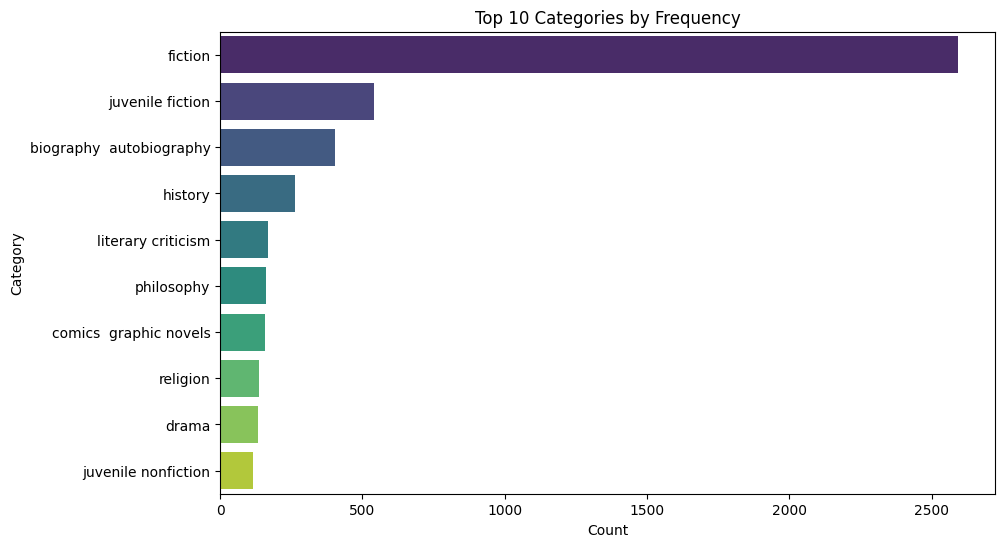


Top 10 Categories by Frequency (Detailed Data):
                Category  Count
                 fiction   2594
        juvenile fiction    540
biography  autobiography    404
                 history    264
      literary criticism    167
              philosophy    160
  comics  graphic novels    159
                religion    137
                   drama    132
     juvenile nonfiction    116


In [ ]:
# Category Distribution
categories = df['categories'].str.split(',').explode().str.strip().value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=categories.values, y=categories.index, palette='viridis')
plt.title('Top 10 Categories by Frequency')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# Print detailed category data
categories_df = categories.reset_index()
categories_df.columns = ['Category', 'Count']
print("\nTop 10 Categories by Frequency (Detailed Data):")
print(categories_df.to_string(index=False))

Interpretasi EDA: Top 10 Kategori Buku Paling Umum

Analisis ini (digambarkan dalam *bar chart* dan tabel data) menunjukkan **10 kategori buku yang paling sering muncul** dalam dataset:

*   **Dominasi Jelas:** Kategori **`fiction` (fiksi)** adalah yang paling dominan, muncul **2594 kali**, jauh mengungguli kategori lainnya.
*   **Peringkat Berikutnya:** Kategori **`juvenile fiction` (fiksi remaja)** (540 kali) dan **`biography autobiography` (biografi/autobiografi)** (404 kali) menempati posisi kedua dan ketiga, namun jumlahnya masih jauh di bawah fiksi.
*   **Kategori Lain:** Kategori populer lainnya seperti `history`, `literary criticism`, `philosophy`, hingga `juvenile nonfiction` muncul dengan frekuensi yang jauh lebih rendah (antara 116 hingga 264 kali).

**Kesimpulan:** Distribusi kategori dalam dataset ini **sangat tidak seimbang**, dengan mayoritas buku termasuk dalam genre fiksi. Hal ini penting untuk diketahui karena dapat mempengaruhi bagaimana sistem rekomendasi akan berperilaku, terutama untuk kategori-kategori yang jumlahnya lebih sedikit.

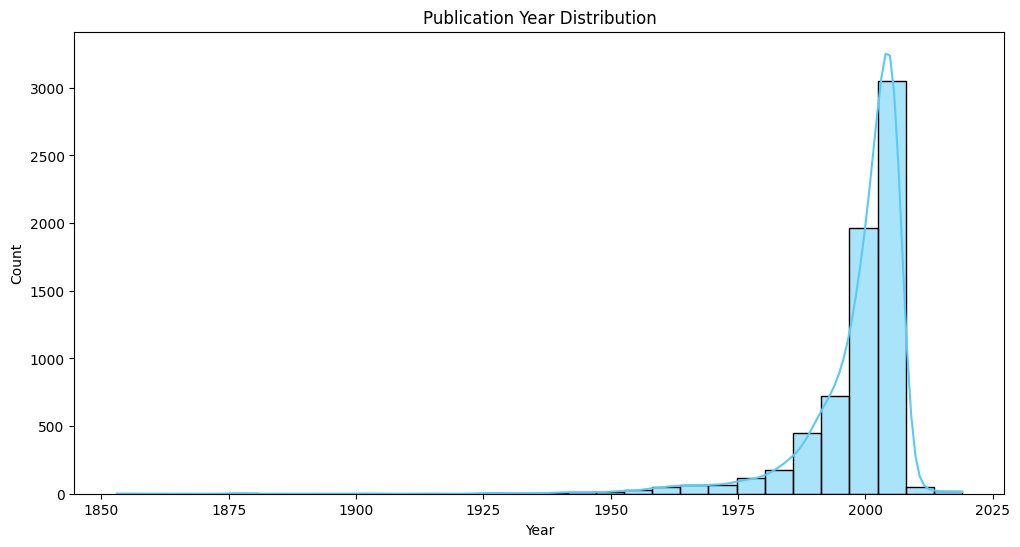

In [ ]:
# Publication Year Trends
df['published_year'] = pd.to_numeric(df['published_year'], errors='coerce')
valid_years = df['published_year'].dropna()

plt.figure(figsize=(12, 6))
sns.histplot(valid_years, bins=30, kde=True, color='#56CBF9')
plt.title('Publication Year Distribution')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

Interpretasi EDA: Distribusi Tahun Publikasi

*   **Konsentrasi pada Era Modern:** Sebagian besar buku dalam dataset diterbitkan dalam beberapa dekade terakhir. Puncak distribusi (jumlah buku terbanyak) berada di sekitar **awal tahun 2000-an**.
*   **Skewed Kiri (Long Tail ke Kiri):** Distribusinya sangat miring (skewed), dengan jumlah buku yang jauh lebih sedikit dari tahun-tahun yang lebih lama (misalnya, sebelum tahun 1975). Ada "ekor" panjang ke arah kiri (tahun-tahun lampau).
*   **Peningkatan Signifikan:** Jumlah buku mulai meningkat secara signifikan sejak sekitar tahun 1970-an dan mencapai puncaknya setelah tahun 2000.

**Kesimpulan:** Dataset ini didominasi oleh buku-buku yang relatif **modern atau baru diterbitkan**, dengan representasi yang jauh lebih kecil untuk buku-buku yang lebih tua.

<ipython-input-11-a1c2857f20d1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=authors.values, y=authors.index, palette='rocket')


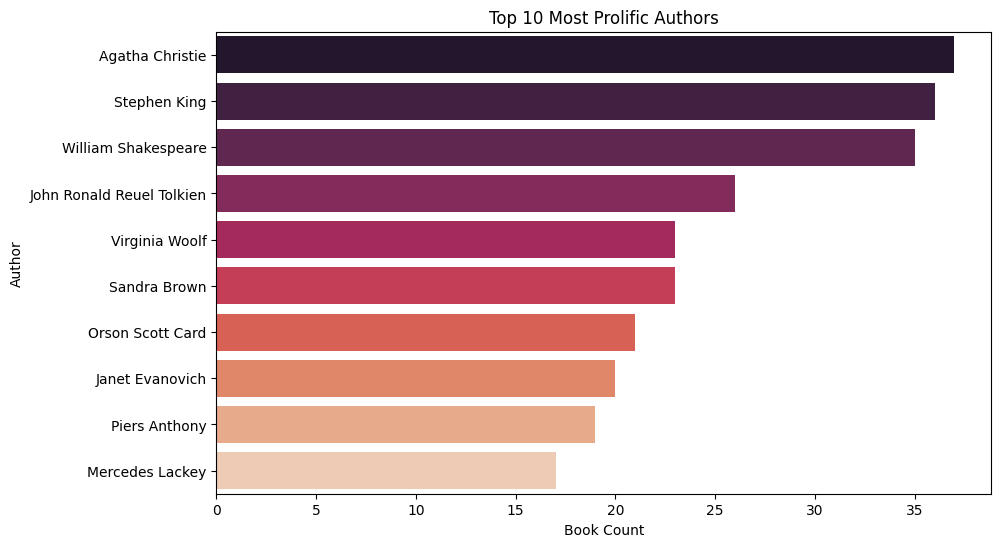

In [ ]:
# Author Popularity
authors = df['authors'].str.split(',').explode().str.strip().value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=authors.values, y=authors.index, palette='rocket')
plt.title('Top 10 Most Prolific Authors')
plt.xlabel('Book Count')
plt.ylabel('Author')
plt.show()

Interpretasi EDA: Top 10 Penulis Paling Produktif

*   **Penulis Teratas:** **Agatha Christie** dan **Stephen King** menempati posisi puncak, menunjukkan bahwa mereka memiliki representasi buku terbanyak dalam koleksi data ini (masing-masing lebih dari 35 buku). **William Shakespeare** juga sangat terwakili.
*   **Representasi Tinggi:** Penulis-penulis lain dalam daftar 10 besar (seperti J.R.R. Tolkien, Virginia Woolf, Sandra Brown, dll.) juga memiliki jumlah buku yang signifikan (umumnya antara 17 hingga 26 buku).
*   **Implikasi:** Ini menunjukkan bahwa karya dari penulis-penulis populer dan produktif ini cukup banyak tersedia dalam dataset, yang dapat mempengaruhi variasi rekomendasi, terutama jika pengguna menyukai karya salah satu penulis ini.

**Kesimpulan:** Dataset ini memiliki representasi yang kuat untuk beberapa penulis yang sangat produktif atau klasik, dengan Agatha Christie dan Stephen King sebagai yang paling dominan dalam hal jumlah karya yang disertakan.

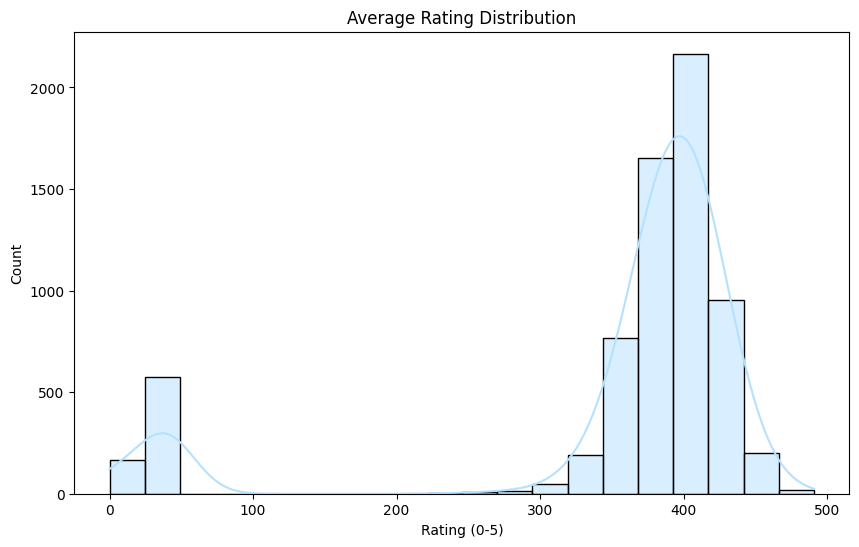

In [ ]:
# Average Rating Distribution
df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')
valid_ratings = df['average_rating'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(valid_ratings, bins=20, kde=True, color='#B4E1FF')
plt.title('Average Rating Distribution')
plt.xlabel('Rating (0-5)')
plt.ylabel('Count')
plt.show()

Interpretasi EDA: Distribusi Rata-Rata Rating

*   **Dominasi Rating Tinggi:** Mayoritas buku cenderung memiliki **rating yang tinggi**. Puncak utama distribusi (jumlah buku terbanyak) berada di sekitar **rating 4.0** (dengan asumsi skala 0-5).
*   **Puncak Kecil di Rating Rendah:** Terdapat juga **kelompok kecil buku** dengan **rating sangat rendah** (mendekati 0 atau 1), yang terlihat sebagai puncak kedua yang jauh lebih kecil.
*   **Distribusi Bimodal:** Pola ini menunjukkan distribusi yang **bimodal** (dua puncak), yang berarti buku-buku cenderung dikelompokkan sebagai "disukai" (rating tinggi) atau "sangat tidak disukai" (rating sangat rendah), dengan lebih sedikit buku yang mendapat rating di tengah-tengah.

**Kesimpulan:** Sebagian besar buku dalam dataset ini memiliki ulasan positif (rating tinggi), namun ada juga sejumlah kecil buku dengan rating yang sangat buruk.

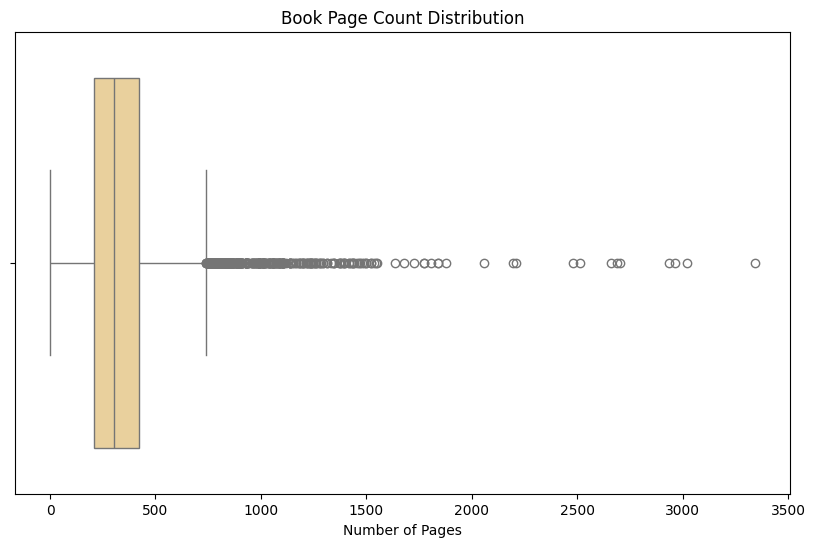

In [ ]:
# Page Count Analysis
df['num_pages'] = pd.to_numeric(df['num_pages'], errors='coerce')
valid_pages = df['num_pages'].dropna()

plt.figure(figsize=(10, 6))
sns.boxplot(x=valid_pages, color='#F5D491')
plt.title('Book Page Count Distribution')
plt.xlabel('Number of Pages')
plt.show()

Interpretasi EDA: Distribusi Jumlah Halaman Buku

*   **Konsentrasi Utama (Box):** Bagian kotak (box) menunjukkan bahwa 50% buku di tengah dataset memiliki jumlah halaman antara sekitar 150-200 hingga 350-400 halaman. Garis di dalam kotak (median) berada di sekitar 250-300 halaman, artinya setengah dari buku memiliki halaman lebih sedikit dari ini, dan setengahnya lebih banyak.
*   **Banyaknya Outlier:** Terdapat **sangat banyak titik** (outlier) di sebelah kanan *whisker* (garis horizontal). Ini menunjukkan bahwa meskipun mayoritas buku memiliki panjang moderat, ada **sejumlah besar buku dengan jumlah halaman yang sangat tinggi** (bisa mencapai lebih dari 1000, 2000, bahkan 3000 halaman) dibandingkan dengan sebagian besar buku lainnya.
*   **Distribusi Miring ke Kanan (Right-Skewed):** Keberadaan banyak outlier dengan nilai tinggi ini membuat distribusi jumlah halaman menjadi sangat **miring ke kanan**.

**Kesimpulan:** Sebagian besar buku dalam dataset memiliki jumlah halaman yang relatif standar (di bawah ~400 halaman), namun terdapat "ekor" panjang yang signifikan dari buku-buku yang sangat tebal.

In [ ]:
# Title Uniqueness Check
unique_titles = df['title'].nunique()
total_titles = len(df)
print(f"Unique Titles: {unique_titles}/{total_titles} ({unique_titles/total_titles:.1%})")

Unique Titles: 6397/6810 (93.9%)


Interpretasi EDA: Pemeriksaan Keunikan Judul

Kode ini memeriksa seberapa unik kolom `title` (judul) dalam dataset:

*   **Hasil:** Dari total **6810** entri buku, terdapat **6397** judul yang unik.
*   **Persentase:** Ini berarti **93.9%** dari buku dalam dataset memiliki judul yang berbeda satu sama lain.

**Kesimpulan:** Sebagian besar buku dalam dataset ini memiliki judul yang unik, menunjukkan bahwa duplikasi judul (buku yang sama persis dicatat berulang kali dengan judul yang sama) sangatlah minim.

## Data Preparation

### Cleaning

In [ ]:
# Text cleaning for text features
for feature in selected_features[:-1]:
    df[feature] = (
        df[feature]
        .astype(str)
        .str.replace('[^a-zA-Z0-9\s]', '', regex=True)
        .str.lower()
    )

# Clean and convert 'published_year' to string
df['published_year'] = (
    df['published_year']
    .astype(str)
    .str.replace(r'[^0-9]', '', regex=True)
    .replace('', '0')
    .astype(int)
    .astype(str)
)

# Combine features into a single string column
df['combined_features'] = (
    df['title'] + ' ' +
    df['authors'] + ' ' +
    df['categories'] + ' ' +
    df['published_year']
)

# Display cleaned data preview
print("\nCleaned Data Preview:")
print(df.head())

# Display combined features sample
print("\nSample Combined Features:")
print(df['combined_features'].head().to_string(index=False))

# Verify no missing values
print("\nMissing Values Check:")
print(df[selected_features].isnull().sum())


Cleaned Data Preview:
          isbn13   isbn10           title subtitle  \
0  9780000000000  2005883          gilead      NaN   
1  9780000000000  2261987     spiders web  A Novel   
2  9780010000000  6163831    the one tree      NaN   
3  9780010000000  6178731  rage of angels      NaN   
4  9780010000000  6280897  the four loves      NaN   

                          authors                     categories  \
0              marilynne robinson                        fiction   
1  charles osborneagatha christie  detective and mystery stories   
2             stephen r donaldson               american fiction   
3                  sidney sheldon                        fiction   
4             clive staples lewis                 christian life   

                                           thumbnail  \
0  http://books.google.com/books/content?id=KQZCP...   
1  http://books.google.com/books/content?id=gA5GP...   
2  http://books.google.com/books/content?id=OmQaw...   
3  http://books.goo

Interpretasi EDA: Pembersihan Teks dan Kombinasi Fitur

1.  **Pembersihan Fitur Teks (`title`, `authors`, `categories`):**
    *   Setiap fitur teks dibersihkan dengan:
        *   Menghapus semua karakter kecuali huruf, angka, dan spasi (`[^a-zA-Z0-9\s]`).
        *   Mengubah semua teks menjadi huruf kecil (`lower()`).
    *   **Tujuan:** Standarisasi teks agar kata-kata seperti "Fiction" dan "fiction" dianggap sama oleh model (TF-IDF), serta menghilangkan "noise" dari tanda baca atau simbol.

2.  **Pembersihan `published_year`:**
    *   Kolom ini secara spesifik dibersihkan untuk hanya menyisakan angka (`[^0-9]`), mengganti nilai kosong/invalid dengan '0', dan dikonversi menjadi string.
    *   **Tujuan:** Memastikan tahun publikasi dalam format numerik string yang konsisten untuk digabungkan.

3.  **Kombinasi Fitur (`combined_features`):**
    *   Fitur-fitur yang telah dibersihkan (`title`, `authors`, `categories`, `published_year`) digabungkan menjadi satu string tunggal untuk setiap buku, dipisahkan oleh spasi.
    *   **Tujuan:** Membuat satu kolom teks yang merangkum informasi konten utama buku, yang akan digunakan sebagai input untuk TF-IDF Vectorizer.

4.  **Verifikasi:**
    *   Pratinjau data (`Cleaned Data Preview`) menunjukkan hasil pembersihan.
    *   Sampel `combined_features` menunjukkan bagaimana fitur-fitur digabungkan.
    *   Pengecekan nilai hilang (`Missing Values Check`) **memastikan bahwa fitur-fitur kunci yang dipilih (`selected_features`) sekarang tidak memiliki nilai hilang** setelah proses pembersihan dan konversi tipe data.

**Kesimpulan:** Proses ini berhasil membersihkan fitur-fitur tekstual dan numerik yang relevan, menggabungkannya menjadi representasi konten tunggal per buku (`combined_features`), dan memastikan tidak ada data yang hilang pada fitur-fitur kunci tersebut, sehingga siap untuk tahap vektorisasi (TF-IDF).

In [ ]:
df.duplicated().sum()

np.int64(0)

There is no duplicate data

In [ ]:
df.isnull().sum()

,0
isbn13,0
isbn10,0
title,0
subtitle,4429
authors,0
categories,0
thumbnail,329
description,263
published_year,0
average_rating,43


Interpretasi EDA: Pemeriksaan Nilai Hilang

Output ini menunjukkan jumlah nilai yang hilang (kosong/NaN) di *setiap kolom* dataset **setelah** proses pembersihan dan pembuatan kolom `combined_features`.

*   **Fitur Inti Lengkap:** Kolom-kolom yang **digunakan secara langsung** untuk membuat `combined_features` (`title`, `authors`, `categories`, `published_year`) dan kolom `combined_features` itu sendiri **tidak memiliki nilai hilang (0 missing values)**. Ini sangat bagus karena memastikan semua buku memiliki profil konten dasar untuk sistem rekomendasi.
*   **Fitur Deskriptif Lainnya:** Fitur seperti `description`, `thumbnail`, `average_rating`, `num_pages`, dan `ratings_count` memiliki sejumlah kecil nilai hilang (antara 43 hingga 329), tetapi mayoritas datanya masih tersedia.
*   **Data Tidak Lengkap:** Kolom `subtitle` memiliki jumlah nilai hilang yang **sangat signifikan (4429 missing values)**, menunjukkan bahwa informasi ini tidak tersedia untuk sebagian besar buku.

**Kesimpulan:** Dataset ini, khususnya fitur-fitur yang dipilih untuk membangun `combined_features`, berada dalam kondisi **siap pakai** (tanpa nilai hilang) untuk tahap selanjutnya (vektorisasi TF-IDF). Namun, jika fitur lain seperti `subtitle` atau `description` ingin digunakan di masa depan, penanganan nilai hilang tambahan mungkin diperlukan.

In [ ]:
# Drop rows with any missing values in selected features
df = df.dropna(subset=selected_features, how='any')

### Tujuan Kode: `df.dropna(subset=selected_features, how='any')`

*   **Tujuan:** Menghapus (drop) **seluruh baris** dari DataFrame `df` jika **minimal satu saja** dari kolom yang ada di dalam daftar `selected_features` (`title`, `authors`, `categories`, `published_year`) memiliki nilai yang hilang (kosong/NaN) pada baris tersebut.
*   **Hasil:** Memastikan bahwa semua baris data yang tersisa memiliki informasi **lengkap** untuk fitur-fitur kunci yang akan digunakan dalam sistem rekomendasi.

In [ ]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

There are 6810 rows and 13 columns.


In [ ]:
df.describe()

,isbn13,average_rating,num_pages,ratings_count
count,6.810000e+03,6767.000000,6767.000000,6.767000e+03
mean,9.780677e+12,354.418354,348.181026,2.106910e+04
std,6.067872e+08,116.563100,242.376783,1.376207e+05
min,9.780000e+12,0.000000,0.000000,0.000000e+00
25%,9.780330e+12,367.000000,208.000000,1.590000e+02
50%,9.780550e+12,392.000000,304.000000,1.018000e+03
75%,9.780810e+12,412.000000,420.000000,5.992500e+03
max,9.789040e+12,491.000000,3342.000000,5.629932e+06


In [ ]:
# Drop unnecessary columns
columns_to_drop = [
    'isbn13',
    'isbn10',
    'thumbnail'
]

df = df.drop(columns=columns_to_drop)

# Total rows and columns in dataset
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

There are 6810 rows and 10 columns.


Tujuan Penghapusan Kolom (`isbn13`, `isbn10`, `thumbnail`)

*   **Menghapus Kolom yang Tidak Relevan:** Kode ini bertujuan untuk menghapus kolom `isbn13`, `isbn10`, dan `thumbnail` dari dataset.
*   **Fokus pada Fitur Konten:** Alasan penghapusan adalah karena kolom-kolom ini (nomor ISBN dan tautan gambar) **tidak dianggap relevan secara langsung** untuk menghitung kemiripan **konten** antar buku dalam sistem rekomendasi berbasis konten (content-based filtering) yang sedang dibangun. Sistem ini lebih fokus pada fitur tekstual seperti judul, penulis, dan kategori.
*   **Efisiensi:** Menghilangkan kolom yang tidak perlu membuat dataset lebih ramping dan fokus pada fitur yang digunakan.

## Model Development

### Content-Based Filtering

In [ ]:
# Combining all the 4 selected features
combined_features = df['title'] + ' ' + df['categories'] + ' ' + df['authors'] + ' ' + f"{df['published_year']}"
combined_features

,0
0,gilead fiction marilynne robinson 0 2004...
1,spiders web detective and mystery stories char...
2,the one tree american fiction stephen r donald...
3,rage of angels fiction sidney sheldon 0 ...
4,the four loves christian life clive staples le...
...,...
6805,i am that philosophy sri nisargadatta maharajs...
6806,secrets of the heart mysticism khalil gibran 0...
6807,fahrenheit 451 book burning ray bradbury 0 ...
6808,the berlin phenomenology history georg wilhelm...


*   **Membuat Representasi Konten Tunggal:** Kode ini bertujuan untuk menggabungkan nilai dari kolom `title`, `categories`, `authors`, dan `published_year` menjadi **satu string teks tunggal** untuk setiap buku.
*   **Input untuk Vektorisasi:** String gabungan (`combined_features`) ini akan berfungsi sebagai **input utama** untuk `TfidfVectorizer`, memungkinkan model untuk menganalisis dan mengubah seluruh informasi konten kunci dari setiap buku menjadi representasi vektor numerik.
``` dari kolom `title`, `categories`, `authors`, dan `published_year` menjadi **satu string teks tunggal** untuk setiap buku.
*   **Input untuk Vektorisasi:** String gabungan ini (`combined_features`) akan berfungsi sebagai **dokumen input** untuk `TfidfVectorizer`. Dengan menggabungkan fitur-fitur ini, TF-IDF dapat menganalisis frekuensi kata di seluruh deskripsi konten gabungan buku untuk menghitung kemiripan antar buku.

In [ ]:
# Converting the text data to feature vectors
vectorizer = TfidfVectorizer()

feature_vectors = vectorizer.fit_transform(combined_features)
print(feature_vectors)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 177818 stored elements and shape (6810, 11517)>
  Coords	Values
  (0, 4223)	0.5877048412221823
  (0, 3717)	0.11178107363861971
  (0, 6597)	0.5877048412221823
  (0, 8794)	0.4395368111916495
  (0, 99)	0.12869711567347136
  (0, 94)	0.06434855783673568
  (0, 80)	0.06434855783673568
  (0, 84)	0.12869711567347136
  (0, 96)	0.06434855783673568
  (0, 125)	0.06434855783673568
  (0, 87)	0.06434855783673568
  (0, 126)	0.06434855783673568
  (0, 127)	0.06434855783673568
  (0, 128)	0.06434855783673568
  (0, 79)	0.06434855783673568
  (0, 129)	0.06434855783673568
  (0, 86)	0.06434855783673568
  (0, 7295)	0.06434855783673568
  (0, 8363)	0.06434855783673568
  (0, 6099)	0.06434855783673568
  (0, 130)	0.06434855783673568
  (0, 3104)	0.06434855783673568
  (0, 7551)	0.06434855783673568
  (1, 99)	0.09957761380014987
  (1, 94)	0.049788806900074936
  :	:
  (6809, 84)	0.09199918223687045
  (6809, 96)	0.045999591118435226
  (6809, 125)	0.0459995911184

*   **Mengubah Teks Menjadi Angka:** Kode ini bertujuan untuk mengubah kolom teks `combined_features` (yang berisi gabungan judul, kategori, penulis, tahun) menjadi **representasi numerik (vektor)** menggunakan metode TF-IDF.
*   **Memungkinkan Perhitungan Matematika:** Representasi vektor numerik ini memungkinkan komputer untuk **mengukur kemiripan** antar buku secara matematis (misalnya, menggunakan Cosine Similarity) pada langkah berikutnya.

In [ ]:
# Calculating similarity scores between items using cosine similarity
similarity = cosine_similarity(feature_vectors, feature_vectors)
print(similarity)

[[1.         0.08009595 0.11570169 ... 0.08443909 0.08173597 0.07400018]
 [0.08009595 1.         0.07988072 ... 0.06533358 0.06324208 0.10431696]
 [0.11570169 0.07988072 1.         ... 0.0842122  0.09369623 0.07380134]
 ...
 [0.08443909 0.06533358 0.0842122  ... 1.         0.06667133 0.06036132]
 [0.08173597 0.06324208 0.09369623 ... 0.06667133 1.         0.05842899]
 [0.07400018 0.10431696 0.07380134 ... 0.06036132 0.05842899 1.        ]]


*   **Mengukur Kemiripan Antar Buku:** Kode ini bertujuan untuk menghitung **skor kemiripan** antara **setiap pasang buku** dalam dataset, berdasarkan representasi vektor numerik (`feature_vectors`) yang dihasilkan oleh TF-IDF.
*   **Membuat Matriks Kemiripan:** Hasilnya adalah sebuah matriks (`similarity`) di mana setiap sel `[i][j]` berisi skor kemiripan (antara 0 dan 1) antara buku ke-`i` dan buku ke-`j`.

In [ ]:
list_of_all_titles = df['title'].tolist()
print(list_of_all_titles)

['gilead', 'spiders web', 'the one tree', 'rage of angels', 'the four loves', 'the problem of pain', 'an autobiography', 'empires of the monsoon', 'the gap into madness', 'master of the game', 'if tomorrow comes', 'assassins apprentice', 'warhost of vastmark', 'the once and future king', 'murder in lamut', 'jimmy the hand', 'well of darkness', 'witness for the prosecution  selected plays', 'the little house', 'mystical paths', 'glittering images', 'glamorous powers', 'the mad ship', 'post captain', 'the reverse of the medal', 'miss marple', 'the years of rice and salt', 'spares', 'gravity', 'the wise woman', 'girls night in', 'the white album', 'the bonesetters daughter', 'the lexus and the olive tree', 'tis', 'ocean star express', 'a small pinch of weather', 'the princess of the chalet school', 'koko', 'tree and leaf', 'partners in crime', 'murder in mesopotamia', 'the lord of the rings the return of the king', 'all families are psychotic', 'death in the clouds', 'appointment with dea

*   **Membuat Daftar Semua Judul:** Kode ini bertujuan untuk mengambil semua nilai dari kolom `title` dalam DataFrame `df` dan menyimpannya ke dalam sebuah **list Python standar**.
*   **Keperluan Pencocokan:** Daftar ini (`list_of_all_titles`) akan digunakan nanti untuk **mencari kecocokan** terdekat antara judul buku yang dimasukkan oleh pengguna dengan judul yang ada di dataset (misalnya menggunakan `difflib`).

In [ ]:
# Asking the user to input a book name
book_name = input(' Enter your favourite book name : ')

# Finding the close match for the book name given by the user
find_close_match = difflib.get_close_matches(book_name, list_of_all_titles)
print(find_close_match)

 Enter your favourite book name : superman
['superman', 'superman', 'son of superman']


*   **Menerima Preferensi Pengguna:** Kode ini bertujuan untuk meminta pengguna memasukkan **judul buku favorit** mereka sebagai input.
*   **Menangani Kesalahan Input:** Kemudian, kode ini menggunakan `difflib` untuk **mencari judul buku yang paling mirip** dalam dataset (`list_of_all_titles`) dengan input pengguna, guna mengatasi kemungkinan salah ketik atau variasi kecil pada judul yang dimasukkan.

In [ ]:
# Find the index of the book with title
close_match = find_close_match[0]
index_of_the_book = df[df.title == close_match].index[0]

# Creating a list of books along with their similarity scores
similarity_score = list(enumerate(similarity[index_of_the_book]))
print(similarity_score)

[(0, np.float64(0.08039443002012212)), (1, np.float64(0.06220407864103423)), (2, np.float64(0.08017840232672904)), (3, np.float64(0.07566597794153865)), (4, np.float64(0.06644440145892136)), (5, np.float64(0.06161681713586672)), (6, np.float64(0.08250762079461044)), (7, np.float64(0.061831159395957236)), (8, np.float64(0.053063680233505134)), (9, np.float64(0.06978644159276637)), (10, np.float64(0.0629806416814753)), (11, np.float64(0.07090308150067105)), (12, np.float64(0.06917909307948349)), (13, np.float64(0.054762354577998766)), (14, np.float64(0.06026834752673093)), (15, np.float64(0.06445031156708937)), (16, np.float64(0.07143222116245267)), (17, np.float64(0.059708375131815525)), (18, np.float64(0.0755493670866442)), (19, np.float64(0.06925480315293933)), (20, np.float64(0.06873521305218754)), (21, np.float64(0.0660136441377388)), (22, np.float64(0.06978692788785294)), (23, np.float64(0.05644928576011307)), (24, np.float64(0.06437885681052813)), (25, np.float64(0.064698091355525

*   **Mengidentifikasi Lokasi Buku Input:** Kode ini bertujuan untuk menemukan **nomor baris (indeks)** dari buku yang paling cocok (`close_match`) di dalam DataFrame `df`.
*   **Mengambil Skor Kemiripan Terkait:** Setelah indeks ditemukan, kode ini mengambil **seluruh baris skor kemiripan** yang bersesuaian dengan buku tersebut dari matriks `similarity`. Fungsi `enumerate` digunakan untuk membuat daftar pasangan yang berisi `(indeks_buku_lain, skor_kemiripan_dengan_buku_input)`.

In [ ]:
# Ranking the books in descending order based on similarity scores
sorted_similar_books = sorted(similarity_score, key = lambda x:x[1], reverse = True)
print(sorted_similar_books)

[(5795, np.float64(1.0000000000000002)), (5866, np.float64(0.4416347106830439)), (6063, np.float64(0.38446276586124994)), (6744, np.float64(0.36244327662559733)), (2525, np.float64(0.3216434436113881)), (2514, np.float64(0.3197810752566479)), (6203, np.float64(0.3072806703690251)), (4820, np.float64(0.3006543365130026)), (4822, np.float64(0.2907813207334346)), (4811, np.float64(0.2893897924168476)), (6383, np.float64(0.2882374112683728)), (4825, np.float64(0.28821105248558104)), (4828, np.float64(0.28401421651279446)), (6059, np.float64(0.2818199601844934)), (6133, np.float64(0.27736596563768245)), (5105, np.float64(0.2750250561961379)), (4826, np.float64(0.27281307500721497)), (4818, np.float64(0.27060393241878933)), (4819, np.float64(0.27060393241878933)), (6132, np.float64(0.2673256455720223)), (6683, np.float64(0.2630773897225832)), (6684, np.float64(0.2630773897225832)), (6052, np.float64(0.26295819705212753)), (6674, np.float64(0.26178269233899015)), (2065, np.float64(0.258167209

*   **Membuat Peringkat Rekomendasi:** Kode ini bertujuan untuk **mengurutkan** daftar buku (`similarity_score`) berdasarkan **skor kemiripannya** dengan buku input pengguna.
*   **Prioritas Kemiripan Tertinggi:** Pengurutan dilakukan dalam urutan **menurun (`reverse=True`)**, sehingga buku-buku yang paling mirip (skor tertinggi) akan muncul di **urutan pertama** dalam daftar `sorted_similar_books`.

In [ ]:
top_sim = sorted_similar_books[:5]
top_sim

[(5795, np.float64(1.0000000000000002)),
 (5866, np.float64(0.4416347106830439)),
 (6063, np.float64(0.38446276586124994)),
 (6744, np.float64(0.36244327662559733)),
 (2525, np.float64(0.3216434436113881))]

*   **Memilih Rekomendasi Terbaik:** Kode ini bertujuan untuk mengambil **5 buku pertama** dari daftar `sorted_similar_books` yang sudah diurutkan.
*   **Mendapatkan Top-N:** Karena daftar tersebut diurutkan berdasarkan kemiripan tertinggi, langkah ini secara efektif memilih **5 buku yang paling mirip** dengan buku input pengguna (termasuk buku input itu sendiri di posisi pertama dengan skor ~1.0) sebagai rekomendasi teratas.

In [ ]:
# Display the titles of the top similar books based on their index
i = 1

for book in sorted_similar_books:
    index = book[0]
    title_from_index = df[df.index==index]['title'].values[0]
    if (i < 6):
        print(i, '-', title_from_index)
        i += 1

1 - superman
2 - gunslinger girl
3 - son of superman
4 - artesia
5 - amphigorey


*   **Menyajikan Hasil Akhir:** Kode ini bertujuan untuk menampilkan **judul buku** dari **5 rekomendasi teratas** (yang sudah diurutkan berdasarkan kemiripan) kepada pengguna.
*   **Konversi Indeks ke Judul:** Ia mengambil indeks buku dari daftar `sorted_similar_books`, mencarinya kembali di DataFrame `df` untuk mendapatkan judul aslinya, dan mencetaknya dalam format yang mudah dibaca (dengan nomor urut 1 sampai 5).

## Evaluasi

In [ ]:
# Evaluation Functions
def evaluate_recommendations(book_titles):
    """Runs evaluation for a list of input book titles."""
    for title in book_titles:
        print(f"\nEvaluating recommendations for: '{title}'")
        recommendations = recommend(title, return_results=True)

        if recommendations:
            display_recommendations(recommendations)
            analyze_similarity_scores(recommendations)
            evaluate_diversity(recommendations)
        else:
            print("Book not found.")

def display_recommendations(recommendations):
    """Displays full details of recommended books with similarity scores."""
    print("\nTop Recommendations:")
    for idx, score in recommendations:
        book_info = df.loc[idx, ['title', 'authors', 'categories', 'published_year']]
        print(f"- Title: {book_info['title']}")
        print(f"  Authors: {book_info['authors']}")
        print(f"  Categories: {book_info['categories']}")
        print(f"  Published Year: {book_info['published_year']}")
        print(f"  Cosine Similarity: {score:.2f}\n")

def analyze_similarity_scores(recommendations):
    """Calculates average and maximum similarity scores for recommendations."""
    scores = [score for _, score in recommendations]
    print(f"\nAverage Similarity Score: {np.mean(scores):.2f}")
    print(f"Highest Similarity Score: {max(scores):.2f}")

def evaluate_diversity(recommendations):
    """Evaluates diversity of recommendations using intra-list similarity."""
    indices = [idx for idx, _ in recommendations]
    intra_similarity = []
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            intra_similarity.append(similarity[indices[i], indices[j]])

    avg_intra = np.mean(intra_similarity) if intra_similarity else 0
    print(f"\nAverage Intra-List Similarity: {avg_intra:.2f}")
    if avg_intra > 0.7:
        print("⚠️ Recommendations lack diversity (high intra-list score)")
    else:
        print("✅ Recommendations have good diversity")

# Recommend Function
def recommend(book_name, return_results=False):
    """Generates recommendations with detailed book information."""
    matches = difflib.get_close_matches(book_name, df['title'], n=1, cutoff=0.6)
    if not matches:
        return None

    close_match = matches[0]
    print(f"\nYou searched for: '{book_name}'")
    print(f"Closest match found: '{close_match}'\n")

    index = df[df['title'] == close_match].index[0]
    similar_books = enumerate(similarity[index])
    sorted_books = sorted(similar_books, key=lambda x: x[1], reverse=True)[1:6]

    if return_results:
        return sorted_books
    else:
        print("Top 5 Recommendations:")
        for idx, score in sorted_books:
            book_info = df.loc[idx, ['title', 'authors', 'categories', 'published_year']]
            print(f"- Title: {book_info['title']}")
            print(f"  Authors: {book_info['authors']}")
            print(f"  Categories: {book_info['categories']}")
            print(f"  Published Year: {book_info['published_year']}")
            print(f"  Cosine Similarity: {score:.2f}\n")

# Book List
test_books = [
    "Gilead",
    "The Four Loves",
    "Rage of Angels",
    "The One Tree",
    "1984"
]

# Run Evaluation
evaluate_recommendations(test_books)


Evaluating recommendations for: 'Gilead'

You searched for: 'Gilead'
Closest match found: 'gilead'


Top Recommendations:
- Title: robinson crusoe
  Authors: daniel defoe
  Categories: fiction
  Published Year: 20030
  Cosine Similarity: 0.30

- Title: the martians
  Authors: kim stanley robinson
  Categories: fiction
  Published Year: 20000
  Cosine Similarity: 0.30

- Title: robinson crusoe
  Authors: daniel defoe
  Categories: juvenile fiction
  Published Year: 20030
  Cosine Similarity: 0.29

- Title: kilo class
  Authors: patrick robinson
  Categories: fiction
  Published Year: 19990
  Cosine Similarity: 0.29

- Title: uss seawolf
  Authors: patrick robinson
  Categories: fiction
  Published Year: 20010
  Cosine Similarity: 0.28


Average Similarity Score: 0.29
Highest Similarity Score: 0.30

Average Intra-List Similarity: 0.36
✅ Recommendations have good diversity

Evaluating recommendations for: 'The Four Loves'

You searched for: 'The Four Loves'
Closest match found: 'the four

#### Evaluasi Sistem Rekomendasi

1.  **`recommend(book_name, return_results=False)`:**
    *   **Tujuan:** Fungsi `recommend` ini dimodifikasi sedikit dari versi sebelumnya.
    *   **Fungsi Utama:** Masih mencari buku yang paling cocok dengan input pengguna dan menghasilkan 5 rekomendasi teratas berdasarkan `cosine_similarity`.
    *   **Fitur Tambahan:**
        *   Menampilkan judul buku yang paling cocok ditemukan (`Closest match found`).
        *   Memiliki parameter `return_results` (jika `True`), fungsi ini akan **mengembalikan** daftar rekomendasi (indeks dan skor) alih-alih mencetaknya langsung. Ini memungkinkan fungsi evaluasi lain untuk menggunakan data mentah ini.
        *   Jika `return_results` adalah `False` (atau tidak disetel), ia akan mencetak detail rekomendasi (judul, penulis, kategori, tahun, skor kemiripan).

2.  **`evaluate_recommendations(book_titles)`:**
    *   **Tujuan:** Fungsi utama untuk menjalankan proses evaluasi pada sekumpulan judul buku.
    *   **Proses:**
        *   Iterasi melalui setiap `title` dalam daftar `book_titles`.
        *   Memanggil `recommend(title, return_results=True)` untuk mendapatkan data rekomendasi mentah.
        *   Jika rekomendasi ditemukan, ia memanggil fungsi-fungsi evaluasi lainnya:
            *   `display_recommendations()`: Menampilkan detail rekomendasi.
            *   `analyze_similarity_scores()`: Menghitung & menampilkan skor kemiripan rata-rata dan tertinggi.
            *   `evaluate_diversity()`: Menghitung & menampilkan skor keragaman (intra-list similarity).

3.  **`display_recommendations(recommendations)`:**
    *   **Tujuan:** Menampilkan hasil rekomendasi dengan lebih detail (termasuk penulis, kategori, tahun) beserta skor kemiripan Cosine.

4.  **`analyze_similarity_scores(recommendations)`:**
    *   **Tujuan:** Mengevaluasi seberapa mirip rekomendasi yang dihasilkan dengan buku input asli, menurut metrik sistem (Cosine Similarity).
    *   **Metrik:** Menghitung skor kemiripan rata-rata dan skor kemiripan tertinggi dari 5 rekomendasi teratas.

5.  **`evaluate_diversity(recommendations)`:**
    *   **Tujuan:** Mengevaluasi seberapa beragam rekomendasi yang diberikan satu sama lain.
    *   **Metrik:** Menghitung rata-rata Cosine Similarity *antar* buku dalam daftar rekomendasi (Intra-List Similarity). Skor tinggi menunjukkan kurangnya keragaman.

6.  **`test_books`:**
    *   **Tujuan:** Sebuah daftar berisi beberapa judul buku yang dipilih untuk dijadikan input pengujian sistem rekomendasi.

7.  **`evaluate_recommendations(test_books)`:**
    *   **Tujuan:** Mengeksekusi seluruh alur evaluasi menggunakan daftar `test_books` sebagai input.

**Kesimpulan:** Blok kode ini menyediakan kerangka kerja untuk menguji sistem rekomendasi pada beberapa contoh input dan menganalisis kualitas outputnya berdasarkan metrik kemiripan (relevansi internal) dan keragaman.

### Interpretasi

In [ ]:
def recommend(book_name):
    # Find closest matching book title
    matches = difflib.get_close_matches(book_name, df['title'], n=1, cutoff=0.6)
    if not matches:
        print("Book not found. Please check the spelling.")
        return

    # Confirm the matched book
    close_match = matches[0]
    print(f"\nYou searched for: '{book_name}'")
    print(f"Closest match found: '{close_match}'\n")

    # Get recommendations
    index = df[df['title'] == close_match].index[0]
    similar_books = enumerate(similarity[index])

    try:
        # Get user input for number of recommendations
        n_recommendations = int(input("Enter the number of recommendations desired: "))
        if n_recommendations < 1:
            raise ValueError("Number must be at least 1")
    except ValueError as e:
        print(f"Invalid input: {e}")
        return

    # Sort and select top recommendations (excluding the input book itself)
    sorted_books = sorted(similar_books, key=lambda x: x[1], reverse=True)[1:n_recommendations+1]

    # Display results with full details
    print(f"Top {n_recommendations} Recommendations:")
    for idx, score in sorted_books:
        book_info = df.loc[idx, [
            'title',
            'authors',
            'categories',
            'published_year',
            'average_rating',
            'num_pages',
            'ratings_count'
        ]]
        print(f"- Title: {book_info['title']}")
        print(f"  Authors: {book_info['authors']}")
        print(f"  Categories: {book_info['categories']}")
        print(f"  Published Year: {book_info['published_year']}")
        print(f"  Average Rating: {book_info['average_rating']}")
        print(f"  Pages: {book_info['num_pages']}")
        print(f"  Ratings Count: {book_info['ratings_count']}")
        print(f"  Cosine Similarity: {score:.2f}\n")

# Get user input with clear instructions
book_name = input("Enter the title of your favorite book: ")

# Execute recommendation
recommend(book_name)

Enter the title of your favorite book: superman

You searched for: 'superman'
Closest match found: 'superman'

Enter the number of recommendations desired (e.g., 5): 3
Top 3 Recommendations:
- Title: gunslinger girl
  Authors: yu aida
  Categories: comics  graphic novels
  Published Year: 20030
  Average Rating: 386.0
  Pages: 175.0
  Ratings Count: 886.0
  Cosine Similarity: 0.44

- Title: son of superman
  Authors: howard v chaykindavid tischman
  Categories: comics  graphic novels
  Published Year: 19990
  Average Rating: 336.0
  Pages: 95.0
  Ratings Count: 11.0
  Cosine Similarity: 0.38

- Title: artesia
  Authors: mark smylie
  Categories: comics  graphic novels
  Published Year: 20110
  Average Rating: 4.0
  Pages: 192.0
  Ratings Count: 236.0
  Cosine Similarity: 0.36



#### Intepretasi Rekomendasi Buku Interaktif

Kode ini mendefinisikan dan menjalankan fungsi `recommend` yang telah diperbarui untuk memberikan rekomendasi buku secara interaktif kepada pengguna dengan lebih banyak detail dan kontrol:

1.  **Input & Pencocokan Judul:**
    *   Fungsi `recommend` menerima `book_name` sebagai input.
    *   Menggunakan `difflib` untuk mencari judul buku yang paling mirip dalam dataset, mengatasi kemungkinan salah ketik.
    *   Memberikan konfirmasi kepada pengguna mengenai judul buku yang ditemukan (`Closest match found`).
    *   Menangani kasus jika tidak ada judul yang cocok ditemukan.

2.  **Jumlah Rekomendasi Dinamis:**
    *   Meminta pengguna untuk **memasukkan jumlah rekomendasi** yang mereka inginkan (`n_recommendations`).
    *   Menyertakan penanganan error jika input yang dimasukkan tidak valid (bukan angka atau kurang dari 1).

3.  **Pengambilan & Pemeringkatan:**
    *   Mengambil skor kemiripan (dari matriks `similarity`) untuk buku yang cocok.
    *   Mengurutkan semua buku lain berdasarkan skor kemiripan secara menurun (dari paling mirip ke kurang mirip).

4.  **Pemilihan Top-N (Tanpa Buku Input):**
    *   Memilih sejumlah (`n_recommendations`) buku teratas dari daftar yang sudah diurutkan.
    *   Secara spesifik **mengabaikan buku input itu sendiri** (dengan memulai *slicing* dari indeks 1), sehingga hanya menampilkan buku *lain* yang mirip.

5.  **Tampilan Hasil Rinci:**
    *   Menampilkan `n_recommendations` teratas kepada pengguna.
    *   Untuk setiap buku yang direkomendasikan, menampilkan **informasi yang lebih lengkap**: Judul, Penulis, Kategori, Tahun Terbit, **Rata-Rata Rating, Jumlah Halaman, Jumlah Rating**, dan Skor Kemiripan Cosine.

6.  **Eksekusi:**
    *   Bagian akhir kode meminta input judul buku dari pengguna dan kemudian memanggil fungsi `recommend` untuk menjalankan seluruh proses rekomendasi.

**Kesimpulan:** Project ini dapat Menciptakan pengalaman rekomendasi yang lebih interaktif, memungkinkan pengguna menentukan jumlah hasil dan menampilkan detail yang lebih kaya untuk setiap buku yang direkomendasikan, sambil memastikan buku input asli tidak muncul dalam daftar rekomendasi.

## Kesimpulan

Proyek ini berhasil mengimplementasikan sebuah **Sistem Rekomendasi Buku Berbasis Konten (Content-Based Filtering)** yang fungsional.

**Hasil Akhir Utama:**

*   **Rekomendasi Berdasarkan Kemiripan Konten:** Sistem mampu merekomendasikan buku kepada pengguna berdasarkan kemiripan **konten** (judul, penulis, kategori, tahun terbit) dengan buku yang mereka sukai.
*   **Proses Inti:** Menggunakan **TF-IDF** untuk mengubah deskripsi konten buku menjadi vektor numerik dan **Cosine Similarity** untuk mengukur seberapa mirip vektor-vektor tersebut.
*   **Interaksi Pengguna:** Pengguna dapat **memasukkan judul buku** favorit mereka.
*   **Output Personalisasi:** Sistem menampilkan **daftar peringkat buku lain** yang paling mirip secara konten, dengan **jumlah rekomendasi yang bisa ditentukan pengguna**, serta menyajikan **detail penting** (seperti rating, jumlah halaman) untuk setiap buku yang direkomendasikan.

Secara singkat, sistem ini efektif dalam menyarankan buku baru kepada pengguna dengan menganalisis kesamaan fitur-fitur kunci dari buku yang telah mereka nikmati.